In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import time
import geopandas as gpd
import seaborn as sns
from sklearn import preprocessing
from sklearn import utils
import shapely.wkt
import contextily as ctx
import matplotlib.pyplot as plt
#necessary libraries in order to import pipeline

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import geoplot as gplt
from shapely.geometry import  Point
import math
from sklearn.impute import SimpleImputer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.ensemble import GradientBoostingClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train = pd.read_csv('/kaggle/input/sf-crime/train.csv.zip')
test = pd.read_csv('/kaggle/input/sf-crime/test.csv.zip')


Data exploration:
1. Explore the dataset and look at features
2. Handle outliers and duplicates
3. Evaluate which ones to keep using intuiton and visualizations

In [4]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Features and Format:

Many of these entries are not numbers and ML models need numbers to function, so one of our jobs is going to be encode these features into numbers. 

Dates - the given date of the crime in the date format. I plan to split this up into multiple features.

Category - the type of crime 

Descript - description of the crime

DayOfWeek - self explanatory

PdDistrict - SF district that the crime took place in

Resolution - outcome of the crime( whether they were arrested)

Address - self-explanatory

X - longitude of the crime

Y - latitude of the crime

Before encoding these into our model, let's look at what features the test data set has.

In [5]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


It looks like in test there are fewer features than in train. Let's look at which ones specifically. 

In test, there is an id that is not present in training, and the idea for the submission is for each id to post a probability of the crime being in a particulat category. The loss function used log-likelihood. So we need to use a multi-class classifier model but we will get to that later.

Which features are different?

There is no Descript, Category, or Resolotion.

Description is the description of a crime and it seems an expansion of category. Let's drop this as it is not available in the test data set.

Category is our target variable so it makes sense that we have the variable for training but not for testing.

Resolution, I will also drop as it is not included in the test set.

<Axes: >

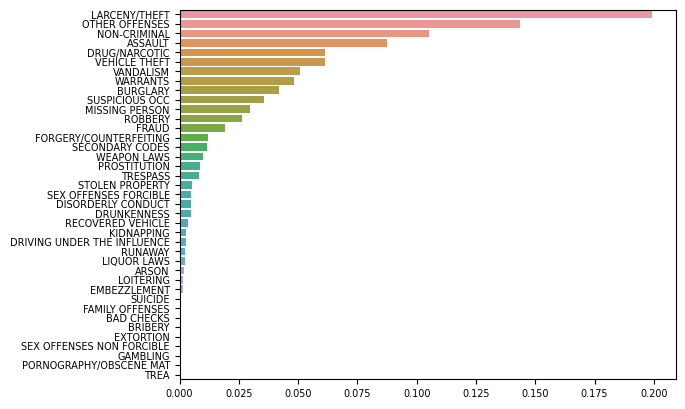

In [6]:
category_percents = train['Category'].value_counts()/ len(train['Category'])
frame = dict(category_percents)
result = pd.DataFrame(frame, index = [0])
result
plt.tick_params(axis='both', which='major', labelsize=7)
sns.barplot(result, orient ='h')

Bar plot of category crime as well as the proportion. Clearly, it looks like Larceny/ Theft is the highest on the list along with other offenses.

<Axes: >

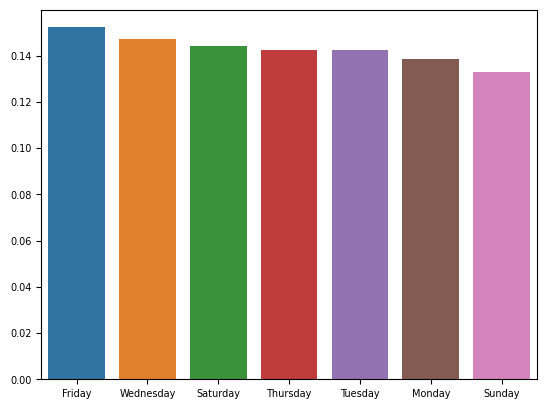

In [7]:
DayOfWeek_crime_percents = train['DayOfWeek'].value_counts()/ len(train['DayOfWeek'])
frame = dict(DayOfWeek_crime_percents)
result = pd.DataFrame(frame, index = [0])
plt.tick_params(axis='both', which='major', labelsize=7)
sns.barplot(result, orient ='v')


<Axes: >

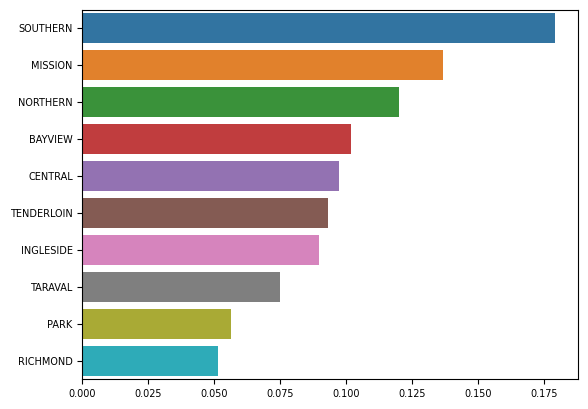

In [8]:
district_crime_percents = train['PdDistrict'].value_counts()/ len(train['PdDistrict'])
frame = dict(district_crime_percents)
result = pd.DataFrame(frame, index = [0])
plt.tick_params(axis='both', which='major', labelsize=7)
sns.barplot(result, orient ='h')


It looks like the majority of crimes are in Southern and Mission so district is definitely worth exploring.

<Axes: >

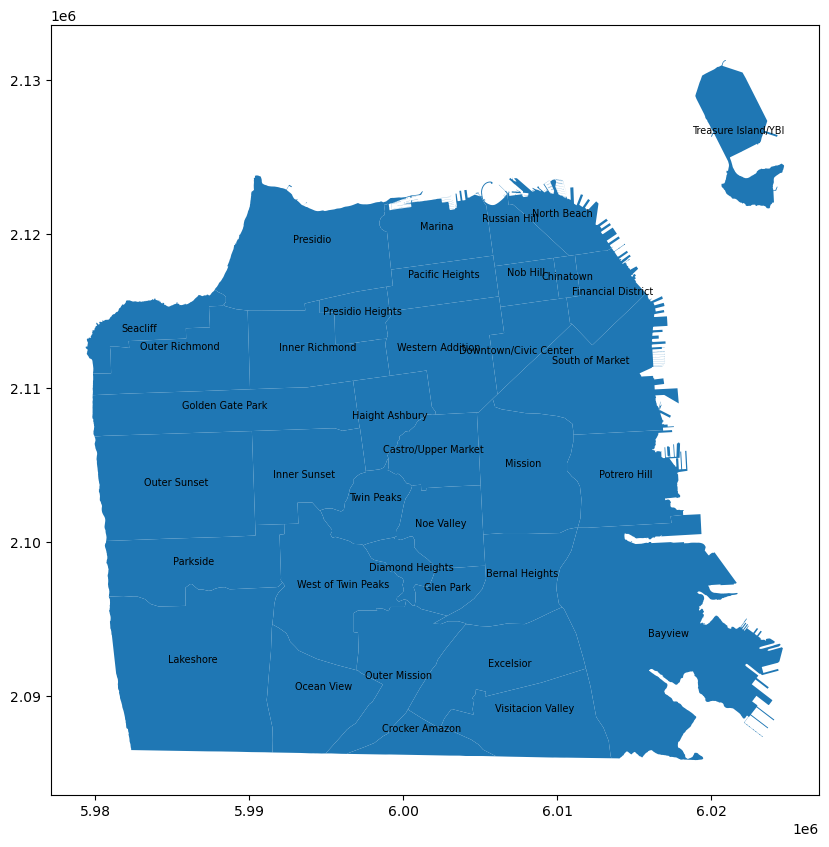

In [74]:
sf_ = gpd.read_file('/kaggle/input/san-francisco-neighborhood-maps/planning_neighborhoods.shx')
sf_['coords'] = sf_['geometry'].apply(lambda x: x.representative_point().coords[:])
sf_['coords'] = [coords[0] for coords in sf_['coords']]
fig, ax = plt.subplots(figsize=(10,10))
# Plot our SF GeoDataFrame
for idx,row in sf_.iterrows():
    plt.annotate(text=row['neighborho'], xy= row['coords'],
                 horizontalalignment='center', fontsize = 7)
sf_.plot(ax=ax, alpha = 1)


There are some points that are not in san francisco that we should locate and change their location to the mean of their district. The latitude 37°45′25.20″ North, longitude 122°26′56.40″ West is the latitude and longitude of sf so let's look and change those that are outside of those bounds.


In [75]:
train['Y'].describe()

count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64

In [76]:
train['X'].describe()

count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64

We can observe that the all the latitudes are in bounds but the longitudes are not so let's use an imputer to take the mean of those latititudes that are out of bounds and replace them with the mean latitude of the PD district they are in.

In [77]:
#Analyze Outliers
#latitude 37°45′25.20″ North, longitude 122°26′56.40″ West is the latitude and longitude of sf
results = train.loc[train['Y']>40]
results


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0


In [78]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

unique = train['PdDistrict'].unique()

for district in unique:
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

In [79]:
#preprocessing date functions( including conversion and creation of new columns)
def convertDate(date):
    ans=''
    for char in str(date):
        if char.isnumeric():
            ans+=char
    return ans
def fullDate(date):
    return str(date)
def retrieveYear(date):
    ans= date[:4]
    return int(ans)
def retrieveMonth(date):
    ans = date[4:6]
    return int(ans)
def retrieveDay(date):
    ans = int(date[6:8])
    return ans % 7
def retrieveHour(date):
    ans = date[8:10]
    return int(ans)

In [80]:
# applying functions to both training and test set
train['Dates'] = train['Dates'].apply(convertDate)
train['fullDate'] = train['Dates'].apply(fullDate)
train['Year']=train['fullDate'].apply(retrieveYear)
train['Month']=train['fullDate'].apply(retrieveMonth)
train['Day']=train['fullDate'].apply(retrieveDay)
train['Hour']=train['fullDate'].apply(retrieveHour)

test['Dates'] = test['Dates'].apply(convertDate)
test['fullDate'] = test['Dates'].apply(fullDate)
test['Year']=test['fullDate'].apply(retrieveYear)
test['Month']=test['fullDate'].apply(retrieveMonth)
test['Day']=test['fullDate'].apply(retrieveDay)
test['Hour']=test['fullDate'].apply(retrieveHour)



In [81]:
#dropping unnecessary features from train and test.
#For test we will rejoin id after training model into final dataframe
train = train.drop(labels = 'Descript', axis =1)
train = train.drop(labels = 'Resolution', axis =1)

ids = test['Id']
test = test.drop(labels ='Id', axis =1)


In [82]:
#making sure we have the same columns in both train and test
train.columns, test.columns

(Index(['Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y',
        'fullDate', 'Year', 'Month', 'Day', 'Hour'],
       dtype='object'),
 Index(['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'fullDate',
        'Year', 'Month', 'Day', 'Hour'],
       dtype='object'))

In [83]:
#encoding all the features in both and train and test
lab_enc = preprocessing.LabelEncoder()
for col in train:
    train[col] = lab_enc.fit_transform(train[col])
for col in test:
    test[col] = lab_enc.fit_transform(test[col])

Now that everything is encoded let's look at correlations and if some are very low we can drop the features.

In [84]:
train.corr()

,Dates,Category,DayOfWeek,PdDistrict,Address,X,Y,fullDate,Year,Month,Day,Hour
Dates,1.000000,-0.021948,-0.008219,0.006997,-0.007244,0.004495,0.024560,1.000000,0.996780,0.031085,0.002148,-0.005941
Category,-0.021948,1.000000,0.000370,-0.040716,0.036401,-0.030597,-0.062973,-0.021948,-0.021734,0.000016,0.003260,0.023577
DayOfWeek,-0.008219,0.000370,1.000000,0.009622,0.000360,-0.000932,-0.005766,-0.008219,-0.007319,-0.006836,-0.002525,-0.001392
PdDistrict,0.006997,-0.040716,0.009622,1.000000,-0.004311,-0.289967,0.289874,0.006997,0.006725,0.001786,-0.000349,0.006386
Address,-0.007244,0.036401,0.000360,-0.004311,1.000000,0.024200,0.114950,-0.007244,-0.007753,0.002541,0.001842,0.026862
X,0.004495,-0.030597,-0.000932,-0.289967,0.024200,1.000000,0.156880,0.004495,0.004401,-0.000171,0.003130,0.001532
Y,0.024560,-0.062973,-0.005766,0.289874,0.114950,0.156880,1.000000,0.024560,0.024095,0.003822,0.002814,-0.010985
fullDate,1.000000,-0.021948,-0.008219,0.006997,-0.007244,0.004495,0.024560,1.000000,0.996780,0.031085,0.002148,-0.005941
Year,0.996780,-0.021734,-0.007319,0.006725,-0.007753,0.004401,0.024095,0.996780,1.000000,-0.048262,0.004066,-0.006266
Month,0.031085,0.000016,-0.006836,0.001786,0.002541,-0.000171,0.003822,0.031085,-0.048262,1.000000,-0.022917,-0.001786


<Axes: >

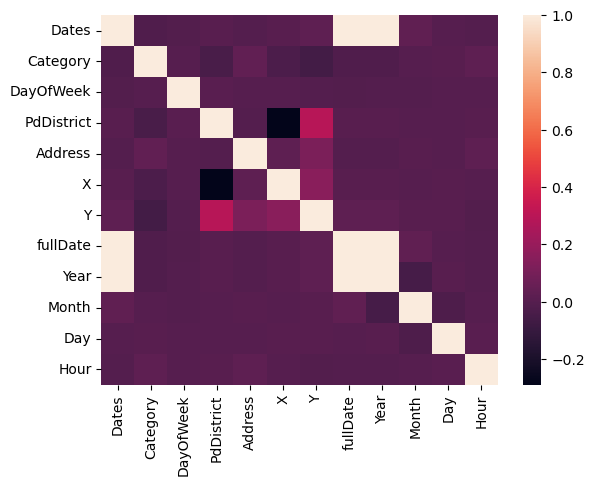

In [85]:
sns.heatmap(train.corr())

I will choose to include the features I have already because they look good at least to the point to where they do not detract from the model.

In [86]:
#dropping category from train set, so I can successfully use train, split Skikit
Y = train['Category']
train= train.drop(labels = 'Category', axis =1)


Something to keep in mind is that categorical encoder encodes alphabetically so it is important to have the column names in alphabetical order. This way, the predictions line up.

In [87]:
#preparing row names and columns for later when we are joining probabilistic predictions with columns

row_names = ids
column_names = np.array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
        'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'])

In [88]:
(train.shape,test.shape)
X_train, X_test, y_train, y_test = train_test_split(train,Y,
                                                    random_state=0)

In [89]:
pipe = Pipeline([('HistGradientBoosting',HistGradientBoostingClassifier ())])
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print(score)

HistGradient is very efficient and took far less time to optimize then random forest or Gradient Boosting. 

In order to optimize, I am going to use GridSearchCV. GridSearchCV requires a dictionary of parameters as well as a search space for those parameters(possible values). Then, GridSearchCV will give us the combination with the least loss.

I have decided to optimize over max_leaf_nodes as well as min_samples_leaf. 

Max_leaf_nodes is a way to control the depth of the tree by capping the number of leaves possible. If there are too many leaves, we are prone to overfitting and the opposite holds true as well. 

Min_samples_leaf will control the minimum number of samples before it can be considered a leaf.

In [93]:
pipe.get_params()

{'memory': None,
 'steps': [('HistGradientBoosting', HistGradientBoostingClassifier())],
 'verbose': False,
 'HistGradientBoosting': HistGradientBoostingClassifier(),
 'HistGradientBoosting__categorical_features': None,
 'HistGradientBoosting__class_weight': None,
 'HistGradientBoosting__early_stopping': 'auto',
 'HistGradientBoosting__interaction_cst': None,
 'HistGradientBoosting__l2_regularization': 0.0,
 'HistGradientBoosting__learning_rate': 0.1,
 'HistGradientBoosting__loss': 'log_loss',
 'HistGradientBoosting__max_bins': 255,
 'HistGradientBoosting__max_depth': None,
 'HistGradientBoosting__max_iter': 100,
 'HistGradientBoosting__max_leaf_nodes': 31,
 'HistGradientBoosting__min_samples_leaf': 20,
 'HistGradientBoosting__monotonic_cst': None,
 'HistGradientBoosting__n_iter_no_change': 10,
 'HistGradientBoosting__random_state': None,
 'HistGradientBoosting__scoring': 'loss',
 'HistGradientBoosting__tol': 1e-07,
 'HistGradientBoosting__validation_fraction': 0.1,
 'HistGradientBoost

In [94]:
submission_predictions = pipe.predict_proba(test)
submission_predictions

In [ ]:
alg = HistGradientBoostingClassifier (warm_start=True)
params = {'max_leaf_nodes':range(30,71,10),
          'min_samples_leaf':[10,20,30]}
clf = GridSearchCV(alg, params, n_jobs =3, cv =5, scoring = 'neg_log_loss')
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
submission_predictions = clf.predict_proba(test)

In [ ]:
#Joining data frame to be formatted correctly and taking a peak at our final result
res = pd.DataFrame(submission_predictions, index=row_names, columns=column_names)
res.to_csv('out.csv')
res